In [1]:
%load_ext autoreload
%autoreload 2

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from root_pandas import read_root

Welcome to JupyROOT 6.10/04


In [2]:
import ROOT

In [3]:
plt.rcParams.update({'font.size': 18})

In [4]:
df_gamma = read_root('/home/david/data/MCC9/November/bnb_ncdelta_cosmics_shrreco.root', key="showerreco3dpandora/_rcshr_tree")
print(df_gamma.shape)

(43858, 23)


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
df_elec = read_root('/home/david/data/MCC9/November/bnb_bnbnue_cosmics_shrreco.root', key="showerreco3dpandora/_rcshr_tree")
print(df_elec.shape)

(185062, 23)


In [6]:
print df_elec.keys()

Index([u'_shr_x', u'_xtimeoffset', u'_xsceoffset', u'_shr_y', u'_shr_z',
       u'_shr_dedx_pl0_v', u'_shr_dedx_pl1_v', u'_shr_dedx_pl2_v', u'_shr_e_v',
       u'_shr_dedx_v', u'_shr_px', u'_shr_py', u'_shr_pz', u'_completeness',
       u'_purity', u'_mc_shr_pdg', u'_mc_shr_e', u'_mc_shr_x', u'_mc_shr_y',
       u'_mc_shr_z', u'_mc_shr_px', u'_mc_shr_py', u'_mc_shr_pz'],
      dtype='object')


In [8]:
df_elec_good = df_elec.query('_purity>0.1 and abs(_shr_pz) > 0.3')
df_gamma_good = df_gamma.query('_mc_shr_pz*_shr_pz > 0.5 and abs(_shr_pz) > 0.3')

In [23]:
dedx_all_gamma_v = df_gamma_good['_shr_dedx_v'].values
dedx_gamma_v = []
for dedxv in dedx_all_gamma_v:
    for dedx in dedxv:
        dedx_gamma_v.append(dedx)
#print dedx_all_gamma_v.flatten('F') # this collapses an array like [[1,2],[3,4]] to 1D: [1,2,3,4]

dedx_all_elec_v = np.array(df_elec_good['_shr_dedx_v'].values)
#dedx_elec_v = dedx_all_elec_v.flatten() # this collapses an array like [[1,2],[3,4]] to 1D: [1,2,3,4]
dedx_elec_v = []
for dedxv in dedx_all_elec_v:
    for dedx in dedxv:
        dedx_elec_v.append(dedx)

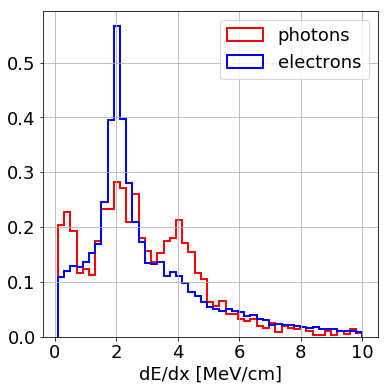

In [31]:
fig = plt.figure(figsize=(6,6))
BINS = np.linspace(0.1,10,50)
plt.hist(dedx_gamma_v,bins=BINS,histtype='step',color='r',lw=2,normed=True,label='photons')
plt.hist(dedx_elec_v ,bins=BINS,histtype='step',lw=2,color='b',normed=True,label='electrons')
plt.grid()
plt.xlabel('dE/dx [MeV/cm]')
plt.legend(loc=1)
plt.show()

In [32]:
# pylandau from https://github.com/SiLab-Bonn/pylandau
from pylandau import langau

In [33]:
from scipy.optimize import curve_fit

In [85]:
# area normalize distributions
# photons
vals_gamma,bine_gamma = np.histogram(dedx_gamma_v,bins=BINS)
valsmax_gamma = np.max(vals_gamma)
vals_gamma = vals_gamma.astype(float)
vals_gamma /= valsmax_gamma
binc_gamma = 0.5*(bine_gamma[1:]+bine_gamma[:-1])
# electrons
vals_elec,bine_elec = np.histogram(dedx_elec_v,bins=BINS)
valsmax_elec = np.max(vals_elec)
vals_elec = vals_elec.astype(float)
vals_elec /= valsmax_elec
binc_elec = 0.5*(bine_elec[1:]+bine_elec[:-1])

In [86]:
guess_gamma = [4.0,0.2,0.2] # MPV, Landau sigma, gauss sigma in that order
guess_elec  = [2.0,0.1,0.1]
#popt_gamma,popv_gamma = curve_fit(landgaunormed,binc_gamma,vals_gamma,p0=guess_gamma)
popt_elec ,popv_elec = curve_fit(langau,binc_elec[10:-1] ,vals_elec[10:-1] ,p0=guess_elec,bounds=([1.9,0,0],[2.2,0.4,0.4]))

In [87]:
print(popt_gamma)
print(popt_elec)

[ 0.74419606 -0.00320441  0.2        -2.72327897]
[1.90000000e+00 1.00000000e-01 6.81345644e-04]


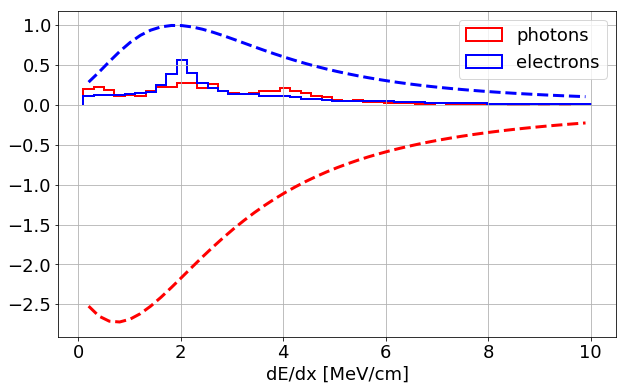

In [88]:
fig = plt.figure(figsize=(10,6))

plt.hist(dedx_gamma_v,bins=BINS,histtype='step',color='r',lw=2,normed=True,label='photons')
plt.hist(dedx_elec_v ,bins=BINS,histtype='step',lw=2,color='b',normed=5,label='electrons')

plt.plot(binc_gamma,langau(binc_gamma,*popt_gamma),'r--',lw=3)
plt.plot(binc_elec,langau(binc_elec,*popt_elec),'b--',lw=3)
plt.grid()
plt.xlabel('dE/dx [MeV/cm]')
plt.legend(loc=1)
plt.show()